# Trying Cat Boost Model

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import f1_score

from preprocess.preprocess_transaction_frequecy import preprocess_transaction_frequency
from preprocess.preprocess_init import preprocess_init
from preprocess.preprocess_time import preprocess_time
from preprocess.preprocess_change_card import preprocess_change_card
from preprocess.preprocess_mchno import preprocess_mchno
from preprocess.preprocess_special_features import preprocess_special_features
from preprocess.preprocess_conam import preprocess_conam
from preprocess.preprocess_train_test_split import preprocess_train_test_split

from util.generate_X_y import generate_X_y
from util.remove_outlier import remove_outlier
from util.generate_statistic import generate_statistic

from model.cat_model import Cat_Model
from model.shap_importance import shap_importance
from model.plot import plot_importance

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

# Define features

These are the features i used in the model

In [2]:
raw_bool_features = ['ecfg',
                     'flbmk',
                     'flg_3dsmk',
                     'insfg',
                     'ovrlt'
                      ]

raw_categorial_features = ['contp',
                           'stscd',
                           'etymd',
                           'stocn',
                           'mcc',
                           'csmcu',
                           'hcefg',
                           'bacno',
                           'cano',
                           'mchno',
                           'acqic',
                           'scity'
                            ] 

raw_contiuous_feautres = ['loctm',
                          'conam',
                          'iterm'
                           ]

transaction_frequency_feautres = ['cano_days_txkey_count',
                                  'cano_locdt_txkey_count',
                                  'bacno_locdt_mchno_txkey_count'
                                    ]

time_feautres = ['last_time_days',
                 'next_time_days',
                 'cano_locdt_global_time_std' 
                    ]


change_card_feautres = ['diff_locdt_with_last_trans_cano',
                        'diff_locdt_of_two_card'
                           ]

conam_feautres = ['cano_locdt_conam_min',
                  'cano_locdt_conam_max',
                  'diff_gtime_with_conam_zero_trans_locdt'
                   ]

mchno_features = ['bacno_mchno_locdt_head_tail_diff',
                  'cano_days_mchno_index',    
                    ]


special_feautures = ['mchno_in_normal_mchno_list',
                    'mchno_in_fraud_mchno_list',
                    'conam_in_fraud_conam_list',
                    'diff_with_first_fraud_locdt'
                               ]

base_features =  (    raw_bool_features 
                    + raw_categorial_features
                    + raw_contiuous_feautres
                    + transaction_frequency_feautres
                    + time_feautres
                    + change_card_feautres
                    + conam_feautres 
                    + mchno_features
                       )

label = 'fraud_ind'

# Preprocess

In [3]:
preprocess_group = False
if preprocess_group:
    df_train_raw = pd.read_csv('data/train.csv')
    df_test_raw = pd.read_csv('data/test.csv')
    df = preprocess_init(df_train_raw, df_test_raw, raw_bool_features)
    df = preprocess_transaction_frequency(df)
    df = preprocess_time(df)
    df = preprocess_change_card(df)
    df = preprocess_mchno(df)
    df = preprocess_conam(df)
    df = preprocess_special_features(df)
    df.to_pickle('data/df_preprocessed.pkl')
else:
    df = pd.read_pickle('data/df_preprocessed.pkl')    

# Base features

In [ ]:
df_test['fraud_ind'] = np.where(df_test['cano'] == 143138, 1, 0)
df_test[['txkey','fraud_ind']].to_csv('testing_143138.csv', index = False)

In [5]:
df_train, df_test = preprocess_train_test_split(df, raw_categorial_features)
input_features = base_features
X_train, y_train, groups, X_test = generate_X_y(df_train, df_test, label, input_features)
X_train[raw_categorial_features] = X_train[raw_categorial_features].astype(str)
# X_train['cano'] = df_train['cano_original']
# X_train['bacno'] = df_train['bacno_original']
# X_test['cano'] = X_test['cano'].astype(int)
# X_test['bacno'] = X_test['bacno'].astype(int)
# groups = X_train['bacno'] 
X_train.tail(10)

,ecfg,flbmk,flg_3dsmk,insfg,ovrlt,contp,stscd,etymd,stocn,mcc,csmcu,hcefg,bacno,cano,mchno,acqic,scity,loctm,conam,iterm,cano_days_txkey_count,cano_locdt_txkey_count,bacno_locdt_mchno_txkey_count,last_time_days,next_time_days,cano_locdt_global_time_std,diff_locdt_with_last_trans_cano,diff_locdt_of_two_card,cano_locdt_conam_min,cano_locdt_conam_max,diff_gtime_with_conam_zero_trans_locdt,bacno_mchno_locdt_head_tail_diff,cano_days_mchno_index
1943429,0,0,0,0,0,5.0,0.0,5.0,102.0,292.0,62.0,5.0,nan,nan,47022,6716.0,4526.0,202808.0,815.08,0,9,1,1,99046.0,NaN,NaN,0,NaN,815.08,815.08,NaN,0,1
1943430,1,0,0,0,0,5.0,0.0,8.0,102.0,209.0,62.0,5.0,nan,nan,38207,6322.0,5817.0,61702.0,750.24,0,9,3,1,NaN,-46675.0,29430.624781,-13,NaN,381.65,841.64,NaN,0,1
1943431,0,0,0,0,0,5.0,0.0,5.0,102.0,270.0,62.0,5.0,nan,nan,39044,6716.0,5820.0,191457.0,841.64,0,9,3,1,46675.0,-7720.0,29430.624781,-13,NaN,381.65,841.64,NaN,0,1
1943432,0,0,0,0,0,5.0,0.0,5.0,102.0,306.0,62.0,5.0,nan,nan,88672,5975.0,5817.0,212337.0,381.65,0,9,3,1,7720.0,-84800.0,29430.624781,-13,NaN,381.65,841.64,NaN,0,1
1943433,0,0,0,0,0,5.0,0.0,5.0,102.0,192.0,62.0,5.0,nan,nan,nan,5975.0,5817.0,205657.0,366.38,0,9,1,1,84800.0,-240959.0,NaN,-12,NaN,366.38,366.38,NaN,0,1
1943434,0,0,0,0,0,5.0,0.0,5.0,102.0,288.0,62.0,5.0,nan,nan,nan,5975.0,5817.0,155256.0,1119.11,0,9,4,1,240959.0,-5347.0,3661.951802,-9,NaN,1103.64,1334.91,NaN,0,1
1943435,0,0,0,0,0,5.0,0.0,5.0,102.0,247.0,62.0,5.0,nan,nan,6475,6767.0,5817.0,172203.0,1334.91,0,9,4,3,5347.0,-2025.0,3661.951802,-9,NaN,1103.64,1334.91,NaN,0,1
1943436,0,0,0,0,0,5.0,0.0,5.0,102.0,247.0,62.0,5.0,nan,nan,6475,6767.0,5817.0,175548.0,1125.71,0,9,4,3,2025.0,-735.0,3661.951802,-9,NaN,1103.64,1334.91,NaN,0,2
1943437,0,0,0,0,0,5.0,0.0,5.0,102.0,247.0,62.0,5.0,nan,nan,6475,6767.0,5817.0,180803.0,1103.64,0,9,4,3,735.0,-749289.0,3661.951802,-9,NaN,1103.64,1334.91,NaN,0,3
1943438,1,0,0,1,0,5.0,0.0,8.0,102.0,247.0,62.0,5.0,nan,nan,82174,6769.0,5817.0,101612.0,1194.66,1,9,1,1,749289.0,NaN,NaN,0,NaN,1194.66,1194.66,NaN,0,1


# Base Model

In [6]:
cat = Cat_Model(input_features, raw_categorial_features)
cat.build_clf()
oof_preds_LGBM, df_sub_preds_LGBM, clf = cat.run(X_train, y_train, groups, X_test, n_splits = 10)

Starting CatGBM. Fold 1,Train shape: (1521787, 33), test shape: (421665, 33)
0:	learn: 0.2488974	test: 0.2494322	test1: 0.2263350	best: 0.2263350 (0)	total: 4.17s	remaining: 1h 9m 28s
10:	learn: 0.6368019	test: 0.6559461	test1: 0.5800871	best: 0.5800871 (10)	total: 42.4s	remaining: 1h 3m 32s
20:	learn: 0.6840672	test: 0.7062424	test1: 0.6078295	best: 0.6078295 (20)	total: 1m 20s	remaining: 1h 2m 9s
30:	learn: 0.7166718	test: 0.7386314	test1: 0.6257398	best: 0.6257398 (30)	total: 1m 58s	remaining: 1h 1m 39s
40:	learn: 0.7341954	test: 0.7575940	test1: 0.6347152	best: 0.6347152 (40)	total: 2m 35s	remaining: 1h 38s
50:	learn: 0.7491239	test: 0.7732828	test1: 0.6424207	best: 0.6424207 (50)	total: 3m 12s	remaining: 59m 44s
60:	learn: 0.7600638	test: 0.7836515	test1: 0.6476806	best: 0.6476806 (60)	total: 3m 50s	remaining: 59m 7s
70:	learn: 0.7691450	test: 0.7916484	test1: 0.6520931	best: 0.6520931 (70)	total: 4m 28s	remaining: 58m 29s
80:	learn: 0.7763868	test: 0.7980204	test1: 0.6542205	best

740:	learn: 0.8646397	test: 0.8754829	test1: 0.6830566	best: 0.6832165 (733)	total: 51m 9s	remaining: 17m 52s
750:	learn: 0.8652401	test: 0.8759930	test1: 0.6829897	best: 0.6832165 (733)	total: 51m 50s	remaining: 17m 11s
760:	learn: 0.8657015	test: 0.8764060	test1: 0.6831218	best: 0.6832165 (733)	total: 52m 31s	remaining: 16m 29s
770:	learn: 0.8663061	test: 0.8769618	test1: 0.6833026	best: 0.6833250 (765)	total: 53m 13s	remaining: 15m 48s
780:	learn: 0.8667076	test: 0.8772612	test1: 0.6831949	best: 0.6833261 (777)	total: 53m 55s	remaining: 15m 7s
790:	learn: 0.8672075	test: 0.8776974	test1: 0.6834193	best: 0.6834501 (786)	total: 54m 36s	remaining: 14m 25s
800:	learn: 0.8675796	test: 0.8780207	test1: 0.6831518	best: 0.6834501 (786)	total: 55m 17s	remaining: 13m 44s
810:	learn: 0.8679191	test: 0.8782573	test1: 0.6830976	best: 0.6834501 (786)	total: 55m 58s	remaining: 13m 2s
820:	learn: 0.8684238	test: 0.8786933	test1: 0.6829977	best: 0.6834501 (786)	total: 56m 40s	remaining: 12m 21s
830:

460:	learn: 0.8467058	test: 0.8665173	test1: 0.7645548	best: 0.7645738 (459)	total: 34m 3s	remaining: 39m 48s
470:	learn: 0.8474118	test: 0.8670397	test1: 0.7651346	best: 0.7651346 (470)	total: 34m 47s	remaining: 39m 5s
480:	learn: 0.8482364	test: 0.8677524	test1: 0.7652917	best: 0.7652917 (480)	total: 35m 32s	remaining: 38m 20s
490:	learn: 0.8491676	test: 0.8685267	test1: 0.7657242	best: 0.7657242 (490)	total: 36m 18s	remaining: 37m 38s
500:	learn: 0.8499708	test: 0.8692423	test1: 0.7657299	best: 0.7658350 (497)	total: 37m 2s	remaining: 36m 53s
510:	learn: 0.8505955	test: 0.8697712	test1: 0.7658128	best: 0.7658491 (505)	total: 37m 48s	remaining: 36m 10s
520:	learn: 0.8511958	test: 0.8702679	test1: 0.7652015	best: 0.7660903 (518)	total: 38m 32s	remaining: 35m 25s
530:	learn: 0.8519505	test: 0.8708809	test1: 0.7658346	best: 0.7660903 (518)	total: 39m 17s	remaining: 34m 41s
540:	learn: 0.8526495	test: 0.8713913	test1: 0.7654143	best: 0.7660903 (518)	total: 40m 2s	remaining: 33m 57s
550:	

400:	learn: 0.8451760	test: 0.8655640	test1: 0.7309544	best: 0.7310254 (363)	total: 29m 51s	remaining: 44m 36s
410:	learn: 0.8459557	test: 0.8662117	test1: 0.7314633	best: 0.7314633 (410)	total: 30m 35s	remaining: 43m 51s
420:	learn: 0.8466990	test: 0.8668684	test1: 0.7317910	best: 0.7317910 (420)	total: 31m 20s	remaining: 43m 6s
430:	learn: 0.8476060	test: 0.8676195	test1: 0.7318158	best: 0.7318325 (422)	total: 32m 6s	remaining: 42m 23s
440:	learn: 0.8485987	test: 0.8684118	test1: 0.7324197	best: 0.7324197 (440)	total: 32m 51s	remaining: 41m 38s
450:	learn: 0.8490682	test: 0.8688072	test1: 0.7323879	best: 0.7325605 (445)	total: 33m 36s	remaining: 40m 55s
460:	learn: 0.8499855	test: 0.8695958	test1: 0.7333097	best: 0.7333097 (460)	total: 34m 21s	remaining: 40m 10s
470:	learn: 0.8505078	test: 0.8699962	test1: 0.7330786	best: 0.7333598 (462)	total: 35m 7s	remaining: 39m 27s
480:	learn: 0.8512924	test: 0.8706773	test1: 0.7333997	best: 0.7336202 (475)	total: 35m 53s	remaining: 38m 43s
490:

190:	learn: 0.8087905	test: 0.8325618	test1: 0.7346946	best: 0.7350346 (186)	total: 14m 9s	remaining: 59m 59s
200:	learn: 0.8111064	test: 0.8344416	test1: 0.7350631	best: 0.7355513 (197)	total: 14m 54s	remaining: 59m 16s
210:	learn: 0.8133269	test: 0.8365251	test1: 0.7372323	best: 0.7372323 (210)	total: 15m 39s	remaining: 58m 31s
220:	learn: 0.8153417	test: 0.8384216	test1: 0.7377764	best: 0.7379118 (215)	total: 16m 23s	remaining: 57m 48s
230:	learn: 0.8173979	test: 0.8403355	test1: 0.7391793	best: 0.7391793 (230)	total: 17m 9s	remaining: 57m 7s
240:	learn: 0.8196901	test: 0.8424216	test1: 0.7400164	best: 0.7406072 (239)	total: 17m 53s	remaining: 56m 21s
250:	learn: 0.8210719	test: 0.8435998	test1: 0.7408187	best: 0.7408970 (249)	total: 18m 39s	remaining: 55m 40s
260:	learn: 0.8226363	test: 0.8449980	test1: 0.7412668	best: 0.7412668 (260)	total: 19m 25s	remaining: 54m 59s
270:	learn: 0.8243952	test: 0.8466169	test1: 0.7411940	best: 0.7413891 (269)	total: 20m 10s	remaining: 54m 15s
280:

300:	learn: 0.8297294	test: 0.8518432	test1: 0.7799104	best: 0.7800407 (297)	total: 22m 22s	remaining: 51m 58s
310:	learn: 0.8310381	test: 0.8529168	test1: 0.7811166	best: 0.7811761 (309)	total: 23m 8s	remaining: 51m 15s
320:	learn: 0.8320159	test: 0.8536604	test1: 0.7811872	best: 0.7812973 (312)	total: 23m 53s	remaining: 50m 32s
330:	learn: 0.8333983	test: 0.8547647	test1: 0.7815748	best: 0.7815748 (330)	total: 24m 39s	remaining: 49m 51s
340:	learn: 0.8343864	test: 0.8555659	test1: 0.7813870	best: 0.7815748 (330)	total: 25m 29s	remaining: 49m 16s
350:	learn: 0.8354644	test: 0.8565333	test1: 0.7811714	best: 0.7815748 (330)	total: 26m 15s	remaining: 48m 32s
360:	learn: 0.8363677	test: 0.8572809	test1: 0.7813902	best: 0.7815748 (330)	total: 27m	remaining: 47m 47s
370:	learn: 0.8370927	test: 0.8577861	test1: 0.7820314	best: 0.7821259 (366)	total: 27m 45s	remaining: 47m 4s
380:	learn: 0.8383086	test: 0.8589008	test1: 0.7825769	best: 0.7826101 (377)	total: 28m 31s	remaining: 46m 20s
390:	le

490:	learn: 0.8502032	test: 0.8700215	test1: 0.7753030	best: 0.7753542 (485)	total: 36m 20s	remaining: 37m 40s
500:	learn: 0.8511845	test: 0.8708364	test1: 0.7759593	best: 0.7759593 (500)	total: 37m 4s	remaining: 36m 55s
510:	learn: 0.8520053	test: 0.8714603	test1: 0.7758624	best: 0.7760161 (502)	total: 37m 48s	remaining: 36m 10s
520:	learn: 0.8527509	test: 0.8720914	test1: 0.7762196	best: 0.7762463 (517)	total: 38m 32s	remaining: 35m 26s
530:	learn: 0.8535248	test: 0.8727972	test1: 0.7763618	best: 0.7766589 (528)	total: 39m 16s	remaining: 34m 41s
540:	learn: 0.8541956	test: 0.8733589	test1: 0.7767747	best: 0.7767747 (540)	total: 40m 1s	remaining: 33m 57s
550:	learn: 0.8547882	test: 0.8738298	test1: 0.7769422	best: 0.7770411 (547)	total: 40m 45s	remaining: 33m 12s
560:	learn: 0.8554590	test: 0.8744180	test1: 0.7772045	best: 0.7772431 (553)	total: 41m 31s	remaining: 32m 29s
570:	learn: 0.8559669	test: 0.8747852	test1: 0.7773366	best: 0.7773405 (569)	total: 42m 15s	remaining: 31m 45s
580

210:	learn: 0.8157067	test: 0.8399493	test1: 0.7640322	best: 0.7642107 (201)	total: 15m 45s	remaining: 58m 55s
220:	learn: 0.8178802	test: 0.8419143	test1: 0.7644641	best: 0.7645755 (219)	total: 16m 30s	remaining: 58m 10s
230:	learn: 0.8193914	test: 0.8431877	test1: 0.7646547	best: 0.7646621 (229)	total: 17m 19s	remaining: 57m 39s
240:	learn: 0.8214446	test: 0.8449835	test1: 0.7638169	best: 0.7646621 (229)	total: 18m 8s	remaining: 57m 6s
250:	learn: 0.8232433	test: 0.8466381	test1: 0.7645729	best: 0.7652038 (246)	total: 18m 53s	remaining: 56m 23s
260:	learn: 0.8244834	test: 0.8476982	test1: 0.7648662	best: 0.7652038 (246)	total: 19m 39s	remaining: 55m 40s
270:	learn: 0.8259798	test: 0.8488743	test1: 0.7661952	best: 0.7661952 (270)	total: 20m 24s	remaining: 54m 55s
280:	learn: 0.8273017	test: 0.8498739	test1: 0.7671861	best: 0.7671861 (280)	total: 21m 9s	remaining: 54m 8s
290:	learn: 0.8285239	test: 0.8510686	test1: 0.7676077	best: 0.7676077 (290)	total: 21m 54s	remaining: 53m 23s
300:	

950:	learn: 0.8756761	test: 0.8894798	test1: 0.7793503	best: 0.7795311 (911)	total: 1h 11m 55s	remaining: 3m 42s
960:	learn: 0.8761859	test: 0.8898797	test1: 0.7792933	best: 0.7795311 (911)	total: 1h 12m 40s	remaining: 2m 56s
970:	learn: 0.8766336	test: 0.8902253	test1: 0.7802573	best: 0.7802573 (970)	total: 1h 13m 26s	remaining: 2m 11s
980:	learn: 0.8771703	test: 0.8906771	test1: 0.7806328	best: 0.7806407 (979)	total: 1h 14m 10s	remaining: 1m 26s
990:	learn: 0.8774801	test: 0.8908458	test1: 0.7806754	best: 0.7807118 (988)	total: 1h 14m 56s	remaining: 40.8s
999:	learn: 0.8779267	test: 0.8911863	test1: 0.7810143	best: 0.7810645 (998)	total: 1h 15m 36s	remaining: 0us

bestTest = 0.7810645323
bestIteration = 998

Shrink model to first 999 iterations.
Starting CatGBM. Fold 8,Train shape: (1521787, 33), test shape: (421665, 33)
0:	learn: 0.4125425	test: 0.4140040	test1: 0.4090433	best: 0.4090433 (0)	total: 4.48s	remaining: 1h 14m 34s
10:	learn: 0.6348674	test: 0.6488545	test1: 0.6382879	bes

670:	learn: 0.8618699	test: 0.8780215	test1: 0.7835751	best: 0.7835751 (670)	total: 49m 51s	remaining: 24m 26s
680:	learn: 0.8622529	test: 0.8783350	test1: 0.7831704	best: 0.7835914 (672)	total: 50m 36s	remaining: 23m 42s
690:	learn: 0.8627384	test: 0.8787027	test1: 0.7832954	best: 0.7835914 (672)	total: 51m 21s	remaining: 22m 57s
700:	learn: 0.8632642	test: 0.8791631	test1: 0.7834787	best: 0.7835914 (672)	total: 52m 6s	remaining: 22m 13s
710:	learn: 0.8638848	test: 0.8796559	test1: 0.7838066	best: 0.7838066 (710)	total: 52m 51s	remaining: 21m 28s
720:	learn: 0.8645672	test: 0.8802759	test1: 0.7836481	best: 0.7838505 (712)	total: 53m 38s	remaining: 20m 45s
730:	learn: 0.8652602	test: 0.8808372	test1: 0.7836784	best: 0.7840053 (723)	total: 54m 24s	remaining: 20m 1s
740:	learn: 0.8659131	test: 0.8814579	test1: 0.7838530	best: 0.7840053 (723)	total: 55m 9s	remaining: 19m 16s
750:	learn: 0.8663428	test: 0.8817897	test1: 0.7837994	best: 0.7840053 (723)	total: 55m 52s	remaining: 18m 31s
760:

390:	learn: 0.8400056	test: 0.8591760	test1: 0.7206559	best: 0.7209500 (370)	total: 29m 18s	remaining: 45m 39s
400:	learn: 0.8411597	test: 0.8601868	test1: 0.7195321	best: 0.7209500 (370)	total: 30m 3s	remaining: 44m 54s
410:	learn: 0.8420208	test: 0.8609103	test1: 0.7200350	best: 0.7209500 (370)	total: 30m 48s	remaining: 44m 9s
420:	learn: 0.8427662	test: 0.8614856	test1: 0.7198736	best: 0.7209500 (370)	total: 31m 34s	remaining: 43m 25s
430:	learn: 0.8437100	test: 0.8623201	test1: 0.7197719	best: 0.7209500 (370)	total: 32m 19s	remaining: 42m 40s
440:	learn: 0.8446746	test: 0.8632689	test1: 0.7203318	best: 0.7209500 (370)	total: 33m 4s	remaining: 41m 55s
450:	learn: 0.8452162	test: 0.8636985	test1: 0.7204565	best: 0.7209500 (370)	total: 33m 48s	remaining: 41m 9s
460:	learn: 0.8460739	test: 0.8644429	test1: 0.7209259	best: 0.7209500 (370)	total: 34m 33s	remaining: 40m 24s
470:	learn: 0.8468317	test: 0.8650948	test1: 0.7213733	best: 0.7214339 (468)	total: 35m 18s	remaining: 39m 39s
480:	

320:	learn: 0.8349591	test: 0.8562511	test1: 0.7458604	best: 0.7458604 (320)	total: 23m 55s	remaining: 50m 37s
330:	learn: 0.8361290	test: 0.8572713	test1: 0.7468697	best: 0.7468697 (330)	total: 24m 40s	remaining: 49m 52s
340:	learn: 0.8371827	test: 0.8581857	test1: 0.7472929	best: 0.7473000 (339)	total: 25m 24s	remaining: 49m 6s
350:	learn: 0.8380753	test: 0.8588459	test1: 0.7474043	best: 0.7475405 (342)	total: 26m 9s	remaining: 48m 21s
360:	learn: 0.8392290	test: 0.8598488	test1: 0.7481867	best: 0.7481867 (360)	total: 26m 54s	remaining: 47m 37s
370:	learn: 0.8401970	test: 0.8606623	test1: 0.7486957	best: 0.7487305 (368)	total: 27m 39s	remaining: 46m 53s
380:	learn: 0.8412214	test: 0.8615699	test1: 0.7488391	best: 0.7488544 (378)	total: 28m 25s	remaining: 46m 10s
390:	learn: 0.8423577	test: 0.8624742	test1: 0.7490417	best: 0.7491036 (387)	total: 29m 10s	remaining: 45m 26s
400:	learn: 0.8433208	test: 0.8632447	test1: 0.7489919	best: 0.7493077 (398)	total: 29m 55s	remaining: 44m 41s
410

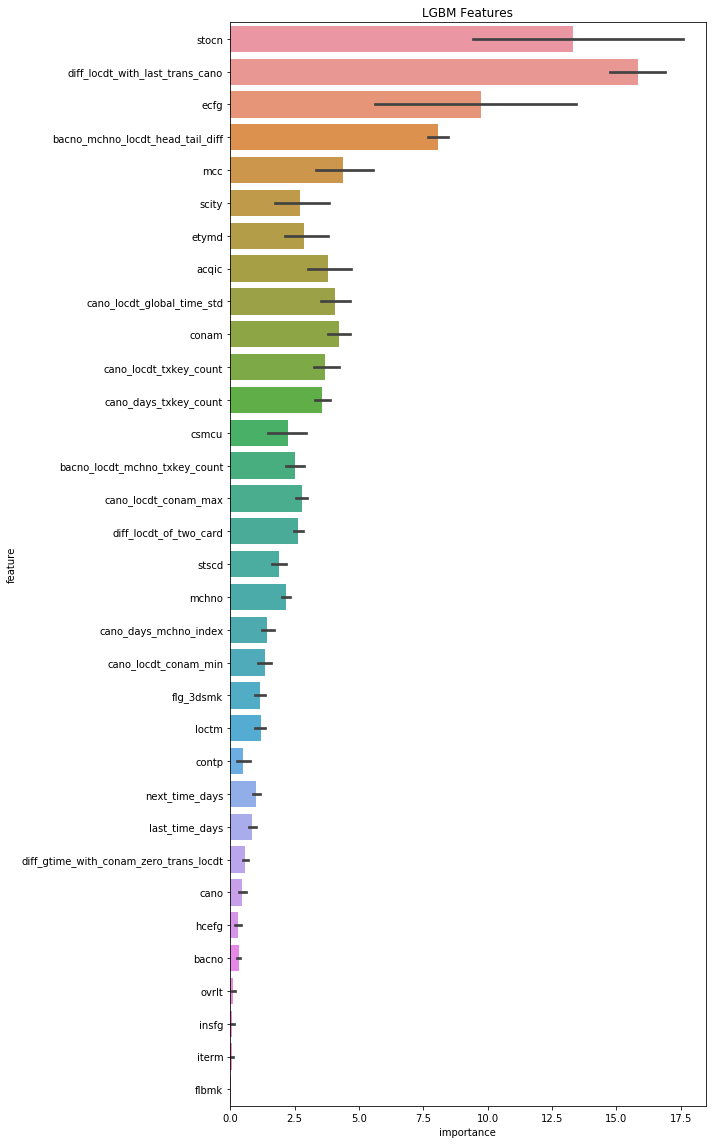

In [22]:
plot_importance(cat.df_feature_importance)

In [23]:
df_sub_preds_statistics = generate_statistic(df_sub_preds_LGBM)
df_sub_preds_statistics.head(10)

,fold_0,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,max,min,std,mean,upper_bound_1std,lower_bound_1std
0,0.117760,0.050136,0.067550,0.132427,0.749206,0.149421,0.048137,0.142727,0.366094,0.206533,0.749206,0.048137,0.202336,0.202999,0.405336,0.000663
1,0.066070,0.051305,0.231061,0.160243,0.569862,0.224074,0.052234,0.468519,0.614868,0.396948,0.614868,0.051305,0.203730,0.283518,0.487248,0.079789
2,0.015093,0.018355,0.046444,0.066118,0.192714,0.067541,0.012649,0.181165,0.119762,0.030082,0.192714,0.012649,0.063862,0.074992,0.138855,0.011130
3,0.081387,0.084472,0.268952,0.218510,0.584686,0.211848,0.031593,0.400643,0.532204,0.205122,0.584686,0.031593,0.179241,0.261942,0.441183,0.082701
4,0.009236,0.019365,0.054952,0.077728,0.114943,0.040566,0.010181,0.132270,0.127951,0.023323,0.132270,0.009236,0.046498,0.061051,0.107549,0.014553
5,0.009187,0.027627,0.085541,0.081958,0.171919,0.042056,0.010694,0.297184,0.227112,0.030390,0.297184,0.009187,0.095070,0.098367,0.193437,0.003297
6,0.124172,0.055881,0.071558,0.178071,0.656155,0.140242,0.013360,0.081565,0.282268,0.091637,0.656155,0.013360,0.176978,0.169491,0.346468,-0.007487
7,0.010903,0.019732,0.030193,0.045681,0.212038,0.025702,0.015846,0.163408,0.109335,0.037875,0.212038,0.010903,0.066696,0.067071,0.133768,0.000375
8,0.012912,0.013668,0.038708,0.099520,0.139723,0.007844,0.003280,0.032087,0.144132,0.026116,0.144132,0.003280,0.051966,0.051799,0.103765,-0.000168
9,0.055886,0.016603,0.021618,0.045960,0.178973,0.019603,0.009106,0.187529,0.157527,0.041978,0.187529,0.009106,0.067993,0.073478,0.141472,0.005485


In [24]:
df_sub_preds_statistics[df_sub_preds_statistics['max'] - df_sub_preds_statistics['min']>0.9].head(10)

,fold_0,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,max,min,std,mean,upper_bound_1std,lower_bound_1std
5600,0.458375,0.464849,0.196384,0.502587,0.868947,0.220098,0.031407,0.397155,0.947462,0.329256,0.947462,0.031407,0.271130,0.441652,0.712782,0.170522
53700,0.110056,0.039868,0.065384,0.047592,0.031844,0.017308,0.017060,0.096685,0.917839,0.300968,0.917839,0.017060,0.263388,0.164461,0.427849,-0.098927
81736,0.006769,0.076882,0.016068,0.240951,0.225374,0.168060,0.073471,0.090207,0.928943,0.422076,0.928943,0.006769,0.263100,0.224880,0.487980,-0.038220
81737,0.013689,0.068973,0.013794,0.191734,0.179069,0.158979,0.085029,0.084949,0.930800,0.354682,0.930800,0.013689,0.259331,0.208170,0.467501,-0.051161
81748,0.008667,0.039664,0.005640,0.165352,0.127727,0.136377,0.076068,0.076834,0.914344,0.250799,0.914344,0.005640,0.254955,0.180147,0.435102,-0.074808
141190,0.589719,0.197653,0.375822,0.478461,0.857966,0.319194,0.034203,0.443489,0.936327,0.596587,0.936327,0.034203,0.263275,0.482942,0.746217,0.219667
181872,0.220380,0.430594,0.108642,0.131886,0.509005,0.104234,0.036362,0.296268,0.950652,0.735035,0.950652,0.036362,0.287236,0.352306,0.639542,0.065070
182486,0.331828,0.425229,0.272277,0.335996,0.924789,0.017957,0.104461,0.223793,0.690988,0.527572,0.924789,0.017957,0.257738,0.385489,0.643227,0.127751
197146,0.022724,0.016889,0.074976,0.016966,0.251751,0.097466,0.156515,0.460695,0.920492,0.262381,0.920492,0.016889,0.266879,0.228085,0.494965,-0.038794
243970,0.375583,0.559906,0.341073,0.520942,0.964151,0.489614,0.326133,0.063003,0.901705,0.652797,0.964151,0.063003,0.257375,0.519491,0.776866,0.262116


# Remove Outier

Since some of the predictions above are very extreme, i drop it if the prediction is out of 1 standard deviation boundary.

In [25]:
df_sub_preds_statistics['mean_remove_outlier'] = df_sub_preds_statistics.apply(remove_outlier, axis = 1)
df_sub_preds_statistics[df_sub_preds_statistics['max'] - df_sub_preds_statistics['min']>0.9][['mean','mean_remove_outlier']].head(10)

,mean,mean_remove_outlier
5600,0.441652,0.366958
53700,0.164461,0.080752
81736,0.224880,0.146651
81737,0.208170,0.127878
81748,0.180147,0.098570
141190,0.482942,0.467212
181872,0.352306,0.257287
182486,0.385489,0.352783
197146,0.228085,0.151151
243970,0.519491,0.466578


In [26]:
df_train['oof_base_model'] = oof_preds_LGBM
df_test['sub_base_model'] = df_sub_preds_statistics['mean_remove_outlier']

## Find the range of threshold which maximizes the f1 score

In [12]:
for i in range(0,70):
    print (i, f1_score(y_train, np.where(df_train['oof_base_model']>i/100,1,0) ))

0 0.026398347233912316
1 0.30786605047535903
2 0.3974225866184294
3 0.45550989441739903
4 0.4984666694930824
5 0.5291607396870555
6 0.5556607469313137
7 0.5758148160868222
8 0.591756817165847
9 0.6050031454686748
10 0.6170034311856651
11 0.6250513347022587
12 0.6338917989523772
13 0.6401763301291863
14 0.6460604043597638
15 0.6515760524645653
16 0.6567639714113493
17 0.6613749672002099
18 0.6654229684411576
19 0.66941683009851
20 0.6732714043838375
21 0.6763300709680412
22 0.6787787623099161
23 0.6807479388913967
24 0.683532127741439
25 0.6855725265103608
26 0.6867792776179588
27 0.6883494421944493
28 0.6892295341077296
29 0.6898767806087595
30 0.6904452098481949
31 0.6909708812852399
32 0.691732835123774
33 0.6919679029770773
34 0.6920200158019489
35 0.6918382509021439
36 0.6917011893625552
37 0.6917799004439662
38 0.6918951132300357
39 0.6915061916971251
40 0.6906664469890436
41 0.6898895027624309
42 0.6894769025515594
43 0.6890883166988174
44 0.6885126012601259
45 0.6878145320893414

## Create Submission

Use different models to predict based on different condiitons. Change the threshold to create submission. 

In [21]:
threshold = 0.40

df_test['fraud_ind'] = np.where(df_sub_preds_LGBM.mean(axis = 1)> threshold, 1, 0)

df_test[['txkey','fraud_ind']].to_csv('result/sub_cat_boost_{}.csv'.format(threshold),index = False)